In [96]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import tensorflow as tf
import numpy as np
from keras import layers

In [97]:
# !curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# !tar -xf aclImdb_v1.tar.gz

In [98]:
# !ls aclImdb

In [99]:
# !ls aclImdb/test

In [100]:
# !ls aclImdb/train

In [101]:
# !cat aclImdb/train/pos/6248_7.txt

In [102]:
# !rm -r aclImdb/train/unsup

In [103]:
batch_size = 32
raw_train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
)
raw_val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
)
raw_test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

print(f"Number of batches in raw_train_ds: {raw_train_ds.cardinality()}")
print(f"Number of batches in raw_val_ds: {raw_val_ds.cardinality()}")
print(f"Number of batches in raw_test_ds: {raw_test_ds.cardinality()}")

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Number of batches in raw_train_ds: 625
Number of batches in raw_val_ds: 157
Number of batches in raw_test_ds: 782


In [104]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print (text_batch.numpy()[i])
        print (label_batch.numpy()[i])

b'I\'ve seen tons of science fiction from the 70s; some horrendously bad, and others thought provoking and truly frightening. Soylent Green fits into the latter category. Yes, at times it\'s a little campy, and yes, the furniture is good for a giggle or two, but some of the film seems awfully prescient. Here we have a film, 9 years before Blade Runner, that dares to imagine the future as somthing dark, scary, and nihilistic. Both Charlton Heston and Edward G. Robinson fare far better in this than The Ten Commandments, and Robinson\'s assisted-suicide scene is creepily prescient of Kevorkian and his ilk. Some of the attitudes are dated (can you imagine a filmmaker getting away with the "women as furniture" concept in our oh-so-politically-correct-90s?), but it\'s rare to find a film from the Me Decade that actually can make you think. This is one I\'d love to see on the big screen, because even in a widescreen presentation, I don\'t think the overall scope of this film would receive its

2024-04-02 15:23:50.682182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [105]:
import string
import re
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )


#model constant
max_features = 20000
embedding_dim =128
sequence_length = 500



vectorize_layer = keras.layers.TextVectorization(
    standardize= custom_standardization,
    max_tokens= max_features,
    output_mode= "int",
    output_sequence_length= sequence_length,
    )

In [106]:
text_ds = raw_test_ds.map(lambda x, y:x)
vectorize_layer.adapt(text_ds)

2024-04-02 15:23:52.869705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [107]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

In [108]:
# A integer input for vocab indices.
inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

in epochs 3, we can see the model is performing better

In [109]:
epochs = 3

# Fit the model using the train and test datasets.
history= model.fit(train_ds, validation_data=val_ds, epochs=epochs)
history

Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.6000 - loss: 0.6163 - val_accuracy: 0.8684 - val_loss: 0.3156
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.8828 - loss: 0.2836 - val_accuracy: 0.8748 - val_loss: 0.3046
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.9438 - loss: 0.1537 - val_accuracy: 0.8694 - val_loss: 0.3723


In [110]:
model.evaluate(test_ds)

782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8636 - loss: 0.3901


[0.3908873200416565, 0.8626000285148621]

In [119]:

sample_sentences = [
    "I love this movie, it's amazing!",
    "This movie is terrible, I hate it."
]

# Convert sentences to numerical format using the vectorization layer
sample_sequences = vectorize_layer(sample_sentences)

# Make predictions
predictions = model.predict(sample_sequences)

# Convert predictions to human-readable labels
labels = ["Negative", "Positive"]
predicted_labels = ["Positive" if pred > 0.5 else "Negative" for pred in predictions]

# Print results
for sentence, predicted_label in zip(sample_sentences, predicted_labels):
    print("Sentence:", sentence)
    print("Predicted Label:", predicted_label)
    print()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Sentence: I love this movie, it's amazing!
Predicted Label: Positive

Sentence: This movie is terrible, I hate it.
Predicted Label: Negative



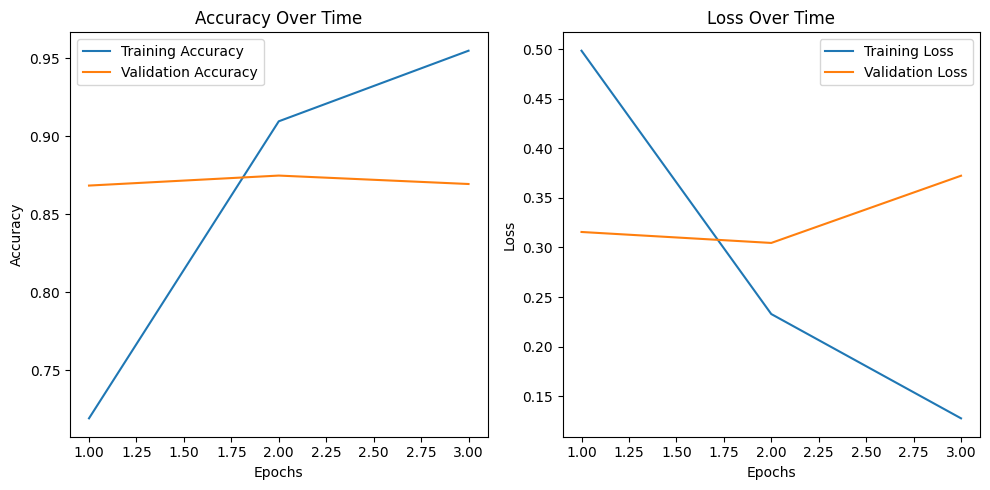

In [111]:
import matplotlib.pyplot as plt
# Extract accuracy and loss from the history object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, epochs + 1)

# Plot accuracy over time
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')
plt.legend()

# Plot loss over time
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()

plt.tight_layout()
plt.show()

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step


2024-04-02 15:25:36.672810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


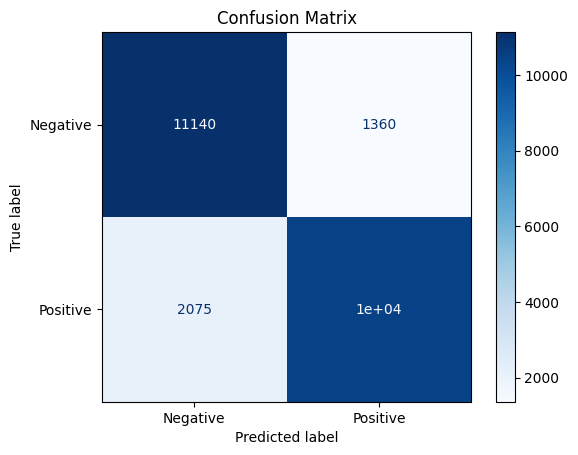

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make predictions on the test dataset
y_pred = (model.predict(test_ds) > 0.5).astype("int32")  # Convert probabilities to binary predictions

# Extract true labels from the test dataset
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix
labels = ['Negative', 'Positive']  
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step


2024-04-02 15:25:44.513304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


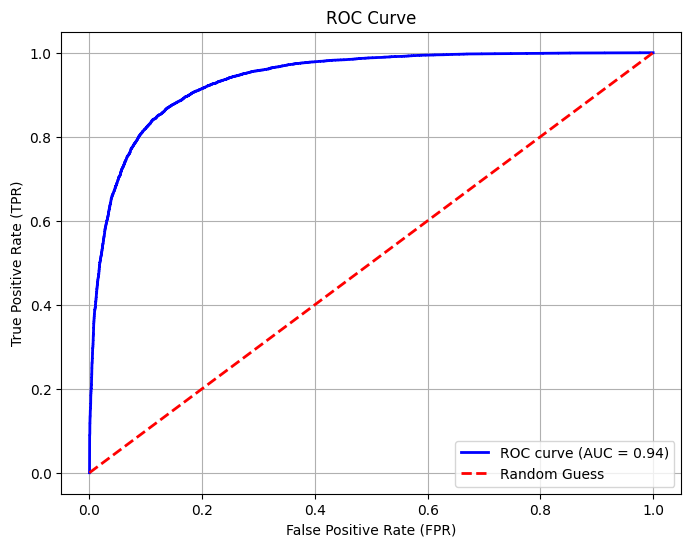

In [113]:

from sklearn.metrics import roc_curve, auc

# Make predictions on the test dataset
y_pred_prob = model.predict(test_ds)

# Flatten the true labels from the test dataset
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

# Compute the area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [114]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Convert predicted probabilities to binary predictions using a threshold (0.5 in this case)
y_pred_binary = (model.predict(test_ds) > 0.5).astype("int32")



# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step
Precision: 0.8845990666100976
Recall: 0.834
F1-score: 0.8585546633724521


In [122]:
# Define the filepath to save the model
model_path = 'sentiment_analysis_model.h5'

# Save the entire model, including the vectorize_layer
model.save(model_path)

